In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
from feature_engine.selection import DropCorrelatedFeatures

## BorutaPy Feature_Selection

In [9]:
# 타이타닉데이터로 보루타 알고리즘으로 피처를 선정하자!

df = sns.load_dataset('titanic')

#데이터 전처리 

df = df.dropna(subset=['age','embarked','deck'])
df['sex'] =df['sex'].map({'male':0,'female':1})
df['embarked'] =df['embarked'].astype('category').cat.codes
df['deck'] = df['deck'].astype('category').cat.codes

#필요한 피처만 추출

X = df[['pclass','sex','age','sibsp','parch','fare','embarked','deck']]
y = df['survived']

In [17]:
# 랜덤포레스트 초기화 가지고 오기!

rf = RandomForestClassifier(class_weight= 'balanced', max_depth=5)

# Borutapy 불러오기
boruta_selector=BorutaPy(rf, n_estimators='auto',random_state=111)
# selector 학습
boruta_selector.fit(X.values, y.values)

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=80,
                                          random_state=RandomState(MT19937) at 0x7FE5C4464140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FE5C4464140)

In [19]:
# 선택된 특성을 출력해 보자!
print('Selected Features:', X.columns[boruta_selector.support_].tolist())

Selected Features: ['sex', 'age', 'fare']


- 모든 특성의 중요도를 평가하고, 그 중요도가 무작위로 생성된 쉐도우 특성의 중요성보다 높은 특성만 선택한 것 
- sex, age, fare

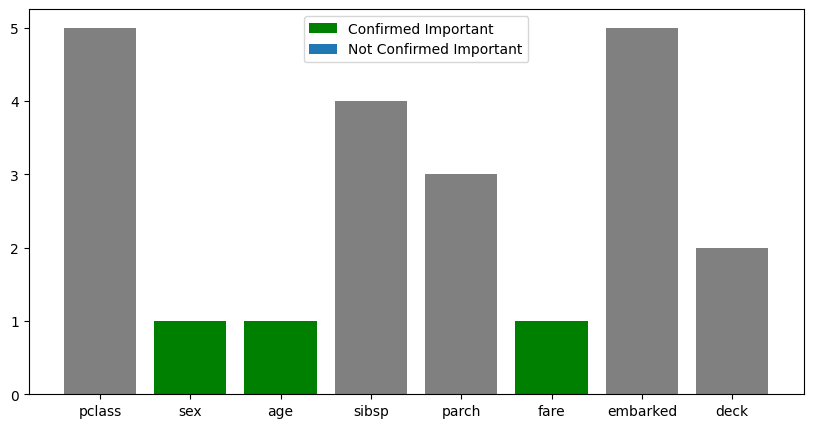

In [29]:
# BorutaPy 시각화
import matplotlib.pyplot as plt 

green_area=X.columns[boruta_selector.support_].tolist()
blue_area = X.columns[boruta_selector.support_weak_].tolist()

# 중요도기반의 랭킹으로 

feat_importances =boruta_selector.ranking_

# 시각화 진행

plt.figure(figsize=(10,5))
plt.bar(X.columns, feat_importances, color = 'grey')
plt.bar(green_area, [1]*len(green_area), color='green',label='Confirmed Important')
plt.bar(blue_area, [2]*len(blue_area), color='blue',label='Not Confirmed Important')
plt.legend()

## Shap를 통한 Feature_Selection

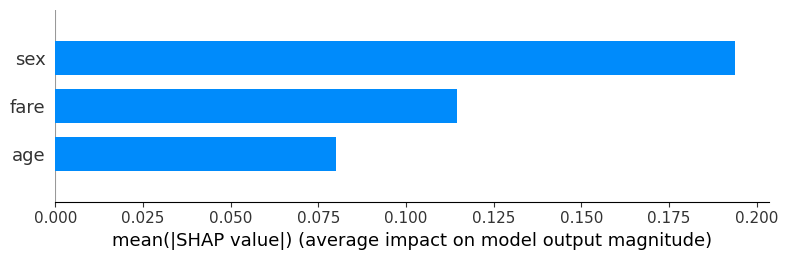

In [36]:
from sklearn.model_selection import train_test_split
# 위에서 sex, age, fare
# 이 세 개의 shap 값은 얼마인지?
# 어떤 식으로 feature selection 하는지도 코드로 이해하자!

import shap

# 중요도가 높은 피처 중에서도 계산을 해서 한 번 확인하자!
X=df[['sex','age','fare']]
y=df['survived']

# 데이터 분할

X_train, X_test, y_train, y_test =train_test_split(X,y, test_size=0.3, random_state=111)

#모델 간단한 학습
model = RandomForestClassifier(random_state=111)
model.fit(X_train, y_train)

## SHAP 값 구하기 
## SHAP Explainer 초기화 및 SHAP 값 계산

explainer = shap.TreeExplainer(model)
shap_values= explainer.shap_values(X_test) # shap 값을 간단하게 계산한다.

# shap 요약 플롯
shap.summary_plot(shap_values[0], X_test, plot_type='bar', feature_names = X_test.columns.tolist())



- Shap 제공하는 다양한 그래프
- summary_plot 외에
- beeswarm plot
- Dependence plot 
- 특성에 대한 상호작용을 시각화 하는 것 

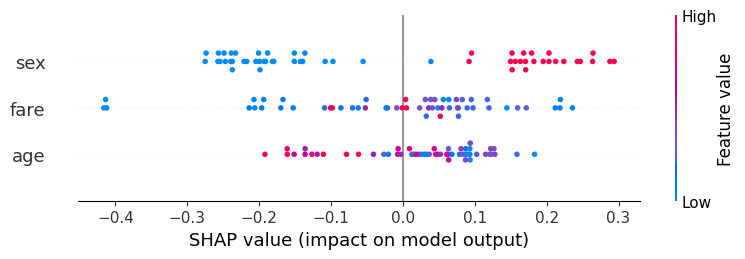

In [46]:
## Shap 시각화
feature_names = X.columns.tolist()
shap.summary_plot(shap_values[1],X_test, feature_names= feature_names)
# Shap 시각화 중 특성들의 영향도를 볼 수 있는 그래프
# 

- Shap model을 다른 모델을 사용해서 Feature 확인해 보자!

Using 127 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/55 [00:00<?, ?it/s]

divide by zero encountered in log
divide by zero encountered in f (vectorized)
invalid value encountered in multiply
invalid value encountered in subtract
invalid value encountered in matmul
divide by zero encountered in double_scalars
divide by zero encountered in log
divide by zero encountered in f (vectorized)
invalid value encountered in multiply
invalid value encountered in subtract
invalid value encountered in matmul
divide by zero encountered in double_scalars


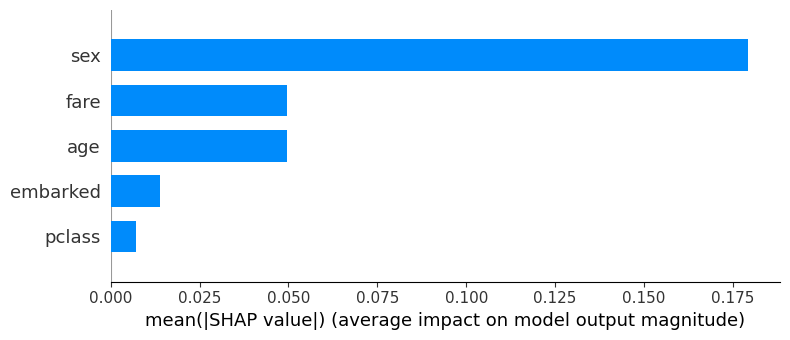

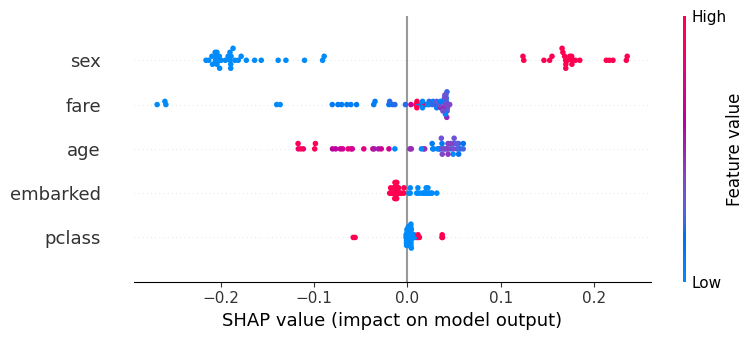

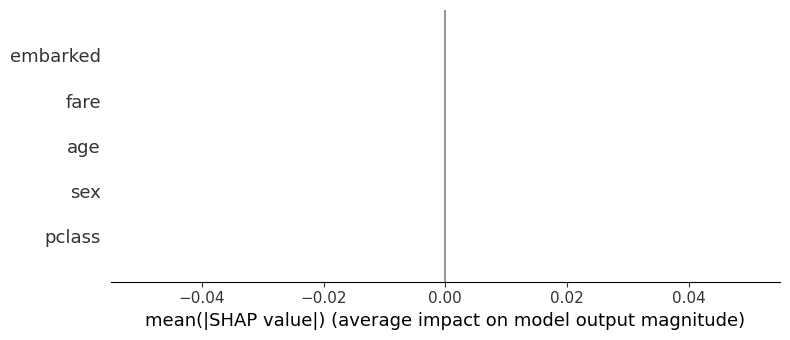

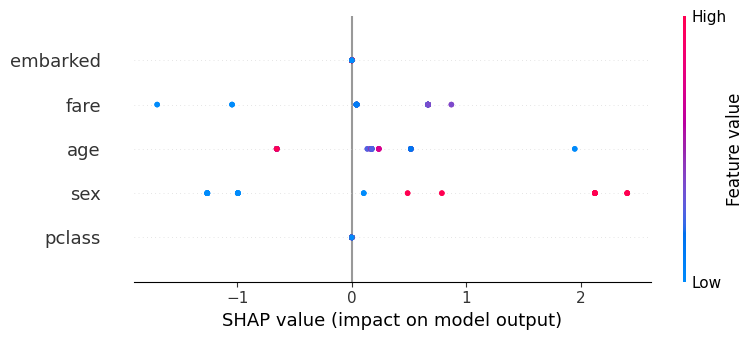

In [55]:
# 결정트리모델
# 랜덤포레스트 모델

# 피처를 좀 더 추가하고 다시 모델을 2개로 비교해서 시각화

from sklearn.tree import DecisionTreeClassifier

X=df[['pclass','sex','age','fare','embarked']]
y=df['survived']

# 데이터 분할

X_train, X_test, y_train, y_test =train_test_split(X,y, test_size=0.3, random_state=111)


# dt 모델
dt_model = DecisionTreeClassifier(max_depth=3)
dt_model.fit(X_train, y_train)

# rf 모델
rf_model = RandomForestClassifier(max_depth=3, random_state=111)
rf_model.fit(X_train, y_train)

# SHAP 다양한 모델을 사용할 수 있다.

# Kernel Explainer
kernel_explainer = shap.KernelExplainer(dt_model.predict_proba, X_train, link='logit')
kernel_values = kernel_explainer.shap_values(X_test, nsamples=100)

# Tree Explainer
tree_explainer = shap.TreeExplainer(rf_model)
tree_shap_values = tree_explainer.shap_values(X_test)

# shap 시각화 Tree

shap.summary_plot(tree_shap_values[1], X_test, plot_type='bar', feature_names=['pclass','sex','age','fare','embarked'])
shap.summary_plot(tree_shap_values[1], X_test, feature_names = ['pclass','sex','age','fare','embarked'])

# shap 시각화 kernel

shap.summary_plot(kernel_values[1], X_test, plot_type='bar', feature_names=['pclass','sex','age','fare','embarked'])
shap.summary_plot(kernel_values[1], X_test, feature_names = ['pclass','sex','age','fare','embarked'])


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,1,38.0,1,0,71.2833,0,First,woman,False,2,Cherbourg,yes,False
3,1,1,1,35.0,1,0,53.1000,2,First,woman,False,2,Southampton,yes,False
6,0,1,0,54.0,0,0,51.8625,2,First,man,True,4,Southampton,no,True
10,1,3,1,4.0,1,1,16.7000,2,Third,child,False,6,Southampton,yes,False
11,1,1,1,58.0,0,0,26.5500,2,First,woman,False,2,Southampton,yes,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1,1,1,47.0,1,1,52.5542,2,First,woman,False,3,Southampton,yes,False
872,0,1,0,33.0,0,0,5.0000,2,First,man,True,1,Southampton,no,True
879,1,1,1,56.0,0,1,83.1583,0,First,woman,False,2,Cherbourg,yes,False
887,1,1,1,19.0,0,0,30.0000,2,First,woman,False,1,Southampton,yes,True


array([5, 1, 1, 4, 3, 1, 5, 2])